In [88]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
from keras_tqdm import TQDMNotebookCallback
import random

In [89]:
import numpy as np
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file, 
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

import os
def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

# First have a look at the mobilenet

In [90]:
model = tf.keras.applications.mobilenet.MobileNet()
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [91]:
angry_image_id = os.listdir('images/angry')[0]
angry_image = load_image(os.path.join('images/angry',angry_image_id))
print(f'shape: {angry_image.shape}')
print(f'type: {type(angry_image)}')
model.predict(angry_image)

shape: (1, 224, 224, 3)
type: <class 'numpy.ndarray'>


array([[9.53631024e-05, 2.31962949e-05, 6.81933481e-04, 3.30424606e-04,
        1.12348323e-04, 4.38294774e-06, 5.88656949e-05, 1.09300508e-05,
        9.79519086e-07, 1.39106187e-05, 3.41318724e-07, 9.68286372e-07,
        9.48348529e-08, 3.75862584e-07, 1.01202522e-06, 5.79523430e-07,
        1.04248272e-06, 2.64079995e-06, 1.90790161e-06, 2.18888886e-06,
        2.66823776e-07, 2.27718192e-05, 2.89540731e-06, 8.60090665e-07,
        1.13135081e-06, 2.61959594e-05, 3.12984889e-06, 7.23174307e-05,
        5.46969713e-05, 4.21530643e-07, 1.28533111e-05, 2.16155226e-04,
        6.48583169e-04, 5.25035357e-05, 4.83813710e-06, 2.04189405e-06,
        2.54021052e-05, 6.22443031e-06, 1.11232053e-04, 3.51475774e-06,
        2.58088239e-05, 1.90766041e-05, 1.57629540e-06, 3.11724853e-06,
        4.43815115e-05, 8.47591946e-06, 1.05603707e-04, 1.29224156e-06,
        1.33550907e-06, 2.77714164e-04, 2.67351832e-04, 2.14632269e-06,
        5.75911952e-04, 8.23839800e-04, 3.23041313e-04, 1.572293

# Now continue without the last layer

In [92]:
model = tf.keras.applications.mobilenet.MobileNet(
# The 3 is the three dimensions of the input: r,g,b.
  input_shape=(224, 224, 3), 
  include_top=False, 
  pooling='avg'
)

In [93]:
angry_image_id = os.listdir('images/angry')[0]
angry_image = load_image(os.path.join('images/angry',angry_image_id))
model.predict(angry_image).shape

(1, 1024)

In [94]:
x = Dropout(rate=0.4)(model.output)
# This determines the number of outputs, and thus the number of categories, in my test case 5: happy, angry, scared, disappointed, sad and nervous.
x = Dense(5)(x)
x = Softmax()(x)
model= Model(model.inputs, x)

In [95]:
for layer in model.layers[:-3]:
    layer.trainable = False

In [96]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy'
)

In [97]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=_mobilenet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

ensure_folder_exists('training_aug')
training = datagen.flow_from_directory( 
    './images', 
    target_size=(224, 224),
    save_to_dir='./training_aug',
    subset='training'
) 

ensure_folder_exists('validation_aug')
validation = datagen.flow_from_directory( 
    './images',
    target_size=(224, 224),
    save_to_dir='./validation_aug',
    subset='validation'
) 

Found 355 images belonging to 5 classes.
Found 37 images belonging to 5 classes.


In [98]:
batch_size = 32

history = model.fit(
    x=training,
    steps_per_epoch=training.samples // batch_size,
    epochs=10,
    validation_data=validation,
    validation_steps=validation.samples // batch_size
)

Epoch 1/10
11/11 [==============================] - 19s 2s/step - loss: 2.1866 - val_loss: 1.7925
Epoch 2/10
11/11 [==============================] - 17s 2s/step - loss: 1.8849 - val_loss: 1.6030
Epoch 3/10
11/11 [==============================] - 17s 2s/step - loss: 1.8771 - val_loss: 1.6209
Epoch 4/10
11/11 [==============================] - 18s 2s/step - loss: 1.6417 - val_loss: 1.5844
Epoch 5/10
11/11 [==============================] - 18s 2s/step - loss: 1.6230 - val_loss: 1.5203
Epoch 6/10
11/11 [==============================] - 18s 2s/step - loss: 1.4928 - val_loss: 1.3682
Epoch 7/10
11/11 [==============================] - 18s 2s/step - loss: 1.4478 - val_loss: 1.3344
Epoch 8/10
11/11 [==============================] - 17s 2s/step - loss: 1.2935 - val_loss: 1.3869
Epoch 9/10
11/11 [==============================] - 17s 2s/step - loss: 1.2699 - val_loss: 1.3062
Epoch 10/10
11/11 [==============================] - 17s 2s/step - loss: 1.2778 - val_loss: 1.4011


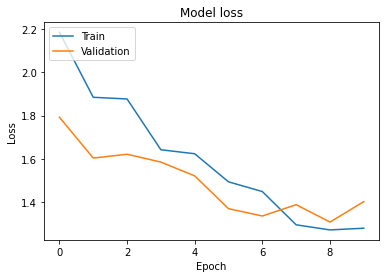

In [133]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [134]:
random_angry = random.choice(os.listdir('images/angry/'))
angry_path = os.path.join('images/angry',random_angry)
angry = load_image(angry_path)
random_happy = random.choice(os.listdir('images/happy/'))
happy_path = os.path.join('images/happy',random_happy)
happy = load_image(happy_path)
random_nervous = random.choice(os.listdir('images/nervous/'))
nervous_path = os.path.join('images/nervous',random_nervous)
nervous = load_image(nervous_path)
random_sad = random.choice(os.listdir('images/sad/'))
sad_path = os.path.join('images/sad',random_sad)
sad = load_image(sad_path)
random_scared = random.choice(os.listdir('images/scared/'))
scared_path = os.path.join('images/scared',random_scared)
scared = load_image(scared_path)

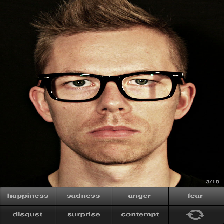

In [135]:
tf.keras.preprocessing.image.load_img(angry_path, target_size=(224,224))

In [136]:
print(f'''angry:{np.round(model.predict(angry),2)}''')

angry:[[0.64 0.03 0.01 0.29 0.04]]


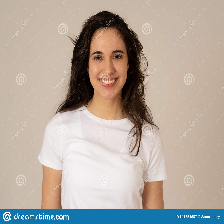

In [137]:
tf.keras.preprocessing.image.load_img(happy_path, target_size=(224,224))

In [138]:
print(f'''happy:{np.round(model.predict(happy),2)}''')

happy:[[0.04 0.66 0.09 0.1  0.11]]


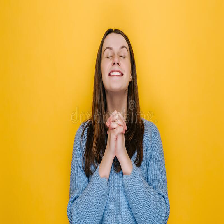

In [139]:
tf.keras.preprocessing.image.load_img(nervous_path, target_size=(224,224))

In [140]:
print(f'''nervous:{np.round(model.predict(nervous),2)}''')

nervous:[[0.17 0.33 0.36 0.08 0.07]]


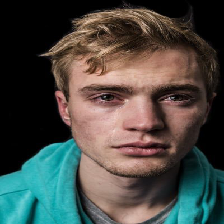

In [141]:
tf.keras.preprocessing.image.load_img(sad_path, target_size=(224,224))

In [142]:
print(f'''sad:{np.round(model.predict(sad),2)}''')

sad:[[0.47 0.05 0.04 0.39 0.06]]


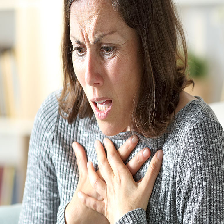

In [143]:
tf.keras.preprocessing.image.load_img(scared_path, target_size=(224,224))

In [144]:
print(f'''scared:{np.round(model.predict(scared),2)}''')

scared:[[0.37 0.07 0.08 0.08 0.4 ]]


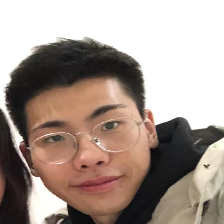

In [145]:
Wang_path = 'Wang.jpg'
Wang = load_image(Wang_path)
tf.keras.preprocessing.image.load_img(Wang_path, target_size=(224,224))

In [146]:
print(f'''Wang:{np.round(model.predict(Wang),2)}''')

Wang:[[0.33 0.09 0.05 0.34 0.2 ]]


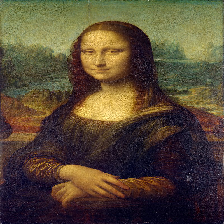

In [150]:
Mona_Lisa_path = 'Mona_Lisa.jpg'
Mona_Lisa = load_image(Mona_Lisa_path)
tf.keras.preprocessing.image.load_img(Mona_Lisa_path, target_size=(224,224))

In [151]:
print(f'''Mona_Lisa:{np.round(model.predict(Mona_Lisa),2)}''')

Mona_Lisa:[[0.39 0.2  0.18 0.13 0.1 ]]
